In [2]:
import datetime
import scipy as scp
from ribbonv2 import *
from samplingv4 import *
from plotResult_v2 import *
import numpy as np
import sklearn.metrics 
import pickle

import warnings

In [3]:
"""
load data cell 1
"""

filename = '../data/cell1.hdf5'
f = h5py.File(filename, 'r')

for item in f.attrs:
    print(item, f.attrs[item])
    
stim_binary = f['stim_binary'][:]
stim_gauss = f['stim_gauss'][:]

r_binary = f['r_binary'][:]
r_gauss = f['r_gauss'][:]

f.close()


# choose data
light = stim_binary
data = r_binary

# stim time with time resolution of dt =1ms
stimT = np.arange(0, len(light),1)/1000


dt[ms] for r = 10
dt[ms] for stim = 1
info: Stim and vesicle release of one cell, 4 recordings per stim, binned sum for r but raw for stim (dt=1)


In [4]:
"""
load data cell 2
"""

filename = '../data/cell2.hdf5'
f = h5py.File(filename, 'r')

for item in f.attrs:
    print(item, f.attrs[item])
    

r_binary_2 = f['r_binary'][:]

f.close()


# choose data
#light = stim_binary
#data = r_binary

# stim time with time resolution of dt =1ms
#stimT = np.arange(0, len(light),1)/1000


dt[ms] for r = 10
dt[ms] for stim = 1
info: Stim and vesicle release of one cell, 2 recordings per stim, binned sum for r but raw for stim (dt=1)


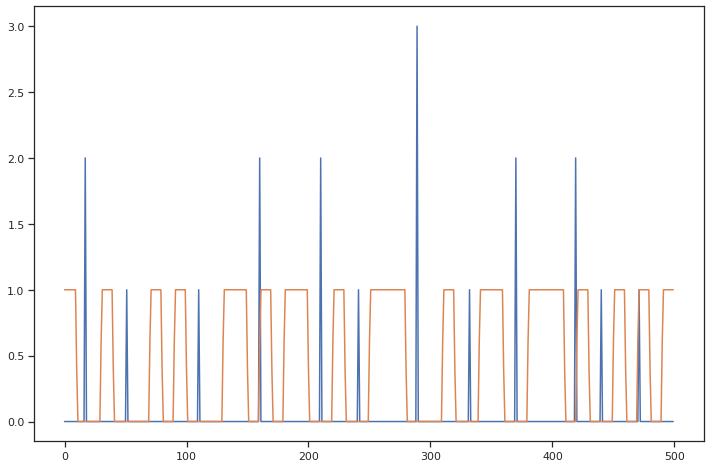

In [5]:
# do resample raw to compare
dtstim = 0.001
stim_raw_Res = resampleCon(light, dtstim)
tRes = np.arange(0, len(light)/100,0.01)

S0 = 10000
S = 10500

plt.figure(1, figsize=(12,8))

plt.plot(r_binary[0][S0:S])

plt.plot(stim_raw_Res[S0:S] )

In [10]:
"""
pickle opening of binary fitting result
"""

filename = 'fitting_results/save_data_v6_3.pkl'

with open(filename, "rb") as f:
    dict_load = pickle.load(f)
    
hypersSave_bin = dict_load['hypers']
outRSave_bin = dict_load['samples']
metaInfo_bin = dict_load['metaInfo']


In [11]:
"""
pickle opening of gauss
"""

filename = 'fitting_results/save_data_gauss_v6_0.pkl'

with open(filename, "rb") as f:
    dict_load = pickle.load(f)
    
hypersSave_gauss = dict_load['hypers']
outRSave_gauss = dict_load['samples']
metaInfo_gauss = dict_load['metaInfo']





In [13]:
w_scale = [5., 5., 5., 5., 2., 2., 4., 2., 1.]

## run simulations

In [14]:
dockMax = 7

ribbonMax = 50

In [15]:
def runOne_with_kernel(params_all, light):
    params = params_all[:-1]
    kernel_scale = params_all[-1]
    # compute stimulus
    # convolve to get Ca trace
    light_ca_kernel =  - celltype * cone_kernel_scale(kernel_scale)
    stimCon = scp.signal.convolve(light, light_ca_kernel, mode="full")[:len(light)]  # /(1/dtstim *10)
    # resample and normalize
    dtstim = 0.001 # in ms
    Ca_raw = resampleCon(stimCon, dtstim)
    # normalize stim
    stim = (Ca_raw - np.min(Ca_raw)) / np.max(np.abs(Ca_raw - np.min(Ca_raw)))

    # run number of simulations according to the batchsize
    rel1 = runOne( params, stim, correlated=True)
    return rel1

In [18]:
"""
Run multiple simulations with the fitted values
# choose therefor paramsfit

binary
"""
np.random.seed(19) # 15 


nfit = 10
celltype = -1

paramsmean =outRSave_bin[-1,:-1,:10].mean(axis=1)
paramsfit_raw = get_expected_values(hypersSave_bin[-1])




# add the maximal dock/ribbon in fitted params
paramsfit = np.zeros(8)
paramsfit[:4] = paramsfit_raw[:4]
paramsfit[4:6] = np.array([dockMax,ribbonMax ])
paramsfit[6] = paramsfit_raw[4]
paramsfit[7] = paramsfit_raw[5]


fit_bin = np.zeros((nfit, len(data[0])) )


for i in range(nfit):
    fit_bin[i] = runOne_with_kernel(paramsfit, stim_binary)
    

In [20]:
"""
Run multiple simulations with the fitted values
# choose therefor paramsfit

gauss
"""
np.random.seed(21) #19 # 15 


nfit = 10
celltype = -1

paramsmean =outRSave_gauss[-1,:-1,:10].mean(axis=1)
paramsfit_raw = get_expected_values(hypersSave_gauss[-1])


# add the maximal dock/ribbon in fitted params
paramsfit = np.zeros(8)
paramsfit[:4] = paramsfit_raw[:4]
paramsfit[4:6] = np.array([dockMax,ribbonMax ])
paramsfit[6] = paramsfit_raw[4]
paramsfit[7] = paramsfit_raw[5]


fit_gauss = np.zeros((nfit, len(data[0])) )


for i in range(nfit):
    fit_gauss[i] = runOne_with_kernel(paramsfit, stim_gauss)


### TJ

In [21]:
"""
define temporal jitter function
"""

def vectorStrength(trace,onset,period,times):
    """
    computes temoral jitter and vector strength
    ---
    :param trace: nTrace array (consisting of the traces for each sim), 
    :param time: the time vector (corresponding to the times for the response array), ?? as integer values??
    :param: onset: the time of stimulus onset, 
    :param: period: period of the stimulus 
    ---
    Outputs: a 10 x nTrace array describing the temporal jitter (tj) or vector strength (vs)
    for each trace (dimension one), and for each quantal event type (up to ten). There must be at 
    least three events of each type in a trace to compute the metrics
    """
    nT = len(trace)#number of traces
    vs = np.zeros((nT,10))
    tj = np.zeros((nT,10))
    for i in range(0,nT): #loop over traces
        x = trace[i]
        get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
        for j in range(0,10): #" loop over quantal types"
            tempToDo = (get_indexes(j,x))
            tempTo = [times[m] for m in tempToDo]
            subtractor = np.ones(len(tempTo))*onset
            tempTo = tempTo-subtractor
            modTime = tempTo % period
            modTime = modTime * 2 * np.pi /period
            #" above computes the event time modulo the stimulus period (after ignoring stim onset)"
            sP = 0
            cP = 0
            for k in range(0,len(modTime)):
                sP = sP+np.sin(modTime[k])
                cP = cP+np.cos(modTime[k])
            if (len(modTime)>2):
                vs[i][j] = float(1)/len(modTime)* np.sqrt(sP**2 + cP**2)
                tj[i][j] =np.sqrt(2*(1-vs[i][j]))/(2*np.pi*1/period)
            else:
                vs[i][j] = float('nan')
                tj[i][j] = float('nan')
    return vs, tj

In [22]:
t_stim = np.arange(0,len(light),10)/1000

vs_data_bin, tj_data_bin = vectorStrength(r_binary,10,0.1,t_stim) 
tj_data_bin = tj_data_bin *1000

vs_data_bin_2, tj_data_bin_2 = vectorStrength(r_binary_2,10,0.1,t_stim) 
tj_data_bin_2 = tj_data_bin_2 *1000


vs_data_gauss, tj_data_gauss = vectorStrength(r_gauss,10,0.1,t_stim)
tj_data_gauss = tj_data_gauss*1000

vs_fit_bin, tj_fit_bin = vectorStrength(fit_bin,10,0.1,t_stim)
tj_fit_bin = tj_fit_bin*1000

vs_fit_gauss, tj_fit_gauss = vectorStrength(fit_gauss,10,0.1,t_stim)
tj_fit_gauss = tj_fit_gauss*1000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


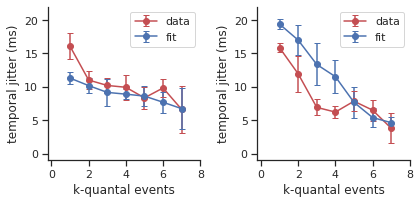

In [23]:

S0 = 1
# mean std of data

# binary data
tj_mean_data_bin = np.nanmean(tj_data_bin, axis=0)
tj_std_data_bin = np.nanstd(tj_data_bin, axis=0)

tj_mean_data_bin_2 = np.nanmean(tj_data_bin_2, axis=0)
tj_std_data_bin_2 = np.nanstd(tj_data_bin_2, axis=0)
#joined
tj_mean_data_bin = np.nanmean(np.vstack([tj_data_bin, tj_data_bin_2]), axis=0)
tj_std_data_bin = np.nanstd(np.vstack([tj_data_bin, tj_data_bin_2]), axis=0)

# gauss data
tj_mean_data_gauss = np.nanmean(tj_data_gauss, axis=0)
tj_std_data_gauss = np.nanstd(tj_data_gauss, axis=0)


# fit bin
tj_mean_fit_bin = np.nanmean(tj_fit_bin, axis=0)
tj_std_fit_bin = np.nanstd(tj_fit_bin, axis=0)


# fit gauss
tj_mean_fit_gauss = np.nanmean(tj_fit_gauss, axis=0)
tj_std_fit_gauss = np.nanstd(tj_fit_gauss, axis=0)



sns.set_style('ticks')
sns.set_context('notebook')
 

plt.figure(1, figsize=(6,3))

plt.subplot(121)
plt.errorbar(np.arange(S0,8), tj_mean_data_bin[S0:-2], tj_std_data_bin[S0:-2], 
             capsize=3, marker='o', label='data', color='r' )

#plt.errorbar(np.arange(S0,8), tj_mean_data_bin_2[S0:-2], tj_std_data_bin[S0:-2], linestyle='--',
#             capsize=3, marker='o', label='cell 2', color='r' )



plt.errorbar(np.arange(S0,8), tj_mean_fit_bin[S0:-2], tj_std_fit_bin[S0:-2], 
             capsize=3, marker='o', label='fit', color='b' )

plt.legend()
#plt.title('temporal jitter binary stimulus')
plt.xlabel('k-quantal events')
plt.ylabel('temporal jitter (ms)')

plt.ylim(-1,22)
plt.xlim(-0.2,8)
plt.xticks([0,2,4,6,8])
plt.yticks([0,5,10,15,20 ])


##
plt.subplot(122)

plt.errorbar(np.arange(S0,9), tj_mean_data_gauss[S0:-1], tj_std_data_gauss[S0:-1], 
             capsize=3, marker='o', label='data', color='r' )

plt.errorbar(np.arange(S0,8), tj_mean_fit_gauss[S0:-2], tj_std_fit_gauss[S0:-2], 
             capsize=3, marker='o', label='fit', color='b' )

plt.ylim(-1,22)
plt.xlim(-0.2,8)
plt.xticks([0,2,4,6,8])
plt.yticks([0,5,10,15,20])


#plt.title('temporal jitter gauss stimulus')
plt.xlabel('k-quantal events')
plt.ylabel('temporal jitter (ms)')
plt.legend()


sns.despine()

plt.tight_layout()


#filename = 'TJ_bin_gauss.svg'
plt.savefig(filename, bbox_inches='tight', format='svg')